# Importing Libraries

In [1]:
# Importing Necessary Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import seaborn as sns
import warnings

In [2]:
# Configuration
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = [15, 7]

# Data Preparation

## Reading Data

In [3]:
# Function to Load Data
def load_data(file_path, company_name, drop_columns):
    data = pd.read_csv(file_path)
    data['company'] = company_name
    return data.drop(columns=drop_columns, errors='ignore')

In [4]:
# Reading Data
data_dir = 'Data'
car_data = {
    'audi': ['audi.csv', 'Audi', ['tax', 'mpg']],
    'bmw': ['bmw.csv', 'BMW', ['tax', 'mpg']],
    'ford': ['ford.csv', 'Ford', []],
    'hyundi': ['hyundi.csv', 'Hyundai', ['tax(£)', 'mpg']],
    'merc': ['merc.csv', 'Mercedes', []],
    'skoda': ['skoda.csv', 'Skoda', ['tax', 'mpg']],
    'toyota': ['toyota.csv', 'Toyota', ['tax', 'mpg']],
    'vauxhall': ['vauxhall.csv', 'Vauxhall', ['tax', 'mpg']],
    'vw': ['vw.csv', 'Volkswagen', ['tax', 'mpg']],
}

## Combining Data

In [5]:
full_data = pd.concat([load_data(os.path.join(data_dir, car_info[0]), car_info[1], car_info[2]) for car_info in car_data.values()])
print(f"Combined Data Shape: {full_data.shape}")

Combined Data Shape: (108540, 8)


## Data Cleaning

#### Checking Statistics of Data

In [6]:
full_data.describe()

,year,price,mileage,engineSize
count,108540.000000,108540.000000,108540.000000,108540.000000
mean,2017.098028,16890.124046,23025.928469,1.661644
std,2.130057,9756.266820,21176.423684,0.557058
min,1970.000000,450.000000,1.000000,0.000000
25%,2016.000000,10229.500000,7491.750000,1.200000
50%,2017.000000,14698.000000,17265.000000,1.600000
75%,2019.000000,20940.000000,32236.000000,2.000000
max,2060.000000,159999.000000,323000.000000,6.600000


Checking Outliers in coumn year

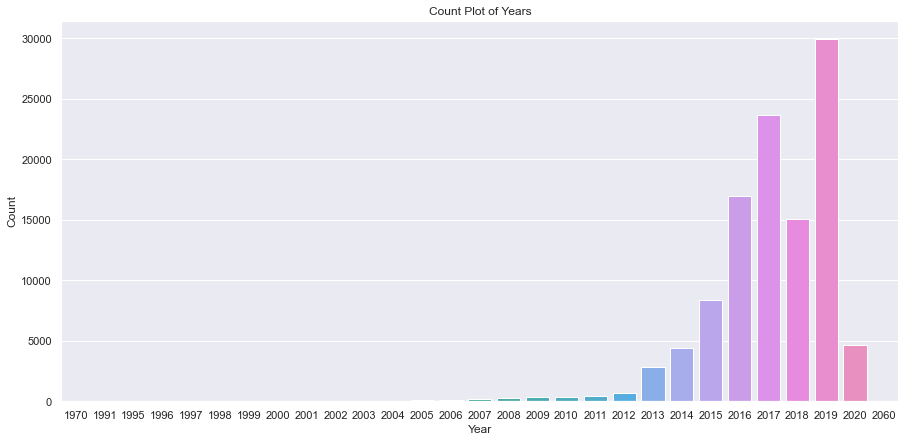

In [7]:
sns.set(style="darkgrid")

# Create a count plot with the new style
sns.countplot(x=full_data['year'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count Plot of Years')
plt.show()

In [8]:
# Data Cleaning
full_data = full_data[full_data['year'] <= 2020]
print(f"Data Shape After Removing Outliers: {full_data.shape}")

Data Shape After Removing Outliers: (108539, 8)


Removing indexes where Year is greater than 2020

In [9]:
index_list = (full_data.loc[full_data['year'] > 2020]).index
full_data = full_data.drop(index_list)

In [10]:
full_data.shape

(108539, 8)

## Data Visualization

In [11]:
# Visualization Functions
def plot_company_distribution(data):
    company_distribution = data['company'].value_counts()
    plt.figure(figsize=(8, 8))  # Set figure size for better readability
    
    # Create a donut chart
    plt.pie(company_distribution.values, labels=company_distribution.index, colors=sns.color_palette('pastel'),
            autopct='%1.1f%%', startangle=140, wedgeprops={'linewidth': 3, 'edgecolor': 'white'})
    
    # Draw a white circle at the center
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    plt.title('Car Distribution by Company', fontsize=20)
    plt.show()


def plot_price_comparison(data):
    plt.figure(figsize=(12, 6))  # Set figure size for better readability

    # Calculate mean price for each company
    mean_prices = data.groupby('company')['price'].mean().reset_index()
    
    # Create a bar plot
    sns.barplot(x='company', y='price', data=mean_prices, palette='muted')
    
    plt.title('Average Price Comparison Among Companies', fontsize=20)
    plt.xlabel('Company')
    plt.ylabel('Average Price')
    plt.xticks(rotation=45)
    plt.show()
    
def plot_price_trend_over_time(data):
    plt.figure(figsize=(12, 8))  # Set figure size for better readability

    # Calculate the mean price for each year and company
    trend_data = data.groupby(['year', 'company'])['price'].mean().reset_index()

    # Create a line plot
    sns.lineplot(x='year', y='price', hue='company', data=trend_data, palette='tab10', marker='o')
    
    plt.title("Average Price Trend Over Time by Company", size=20)
    plt.xlabel("Year")
    plt.ylabel("Average Price")
    plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

def plot_mileage_heatmap(data):
    plt.figure(figsize=(14, 8))  # Set figure size for better readability

    # Create a pivot table with average mileage for each company and year
    mileage_data = data.pivot_table(index='year', columns='company', values='mileage', aggfunc='mean')

    # Create a heatmap
    sns.heatmap(mileage_data, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=.5)
    
    plt.title("Heatmap of Average Mileage by Company and Year", size=20)
    plt.xlabel("Company", size=15)
    plt.ylabel("Year", size=15)
    plt.xticks(rotation=45)
    plt.show()

def plot_engine_size_distribution(data):
    plt.figure(figsize=(14, 8))  # Set figure size for better readability

    # Create a boxen plot
    sns.boxenplot(data=data, x="company", y="engineSize", palette="mako")
    
    plt.title("Engine Size Distribution Among Companies", size=20)
    plt.xlabel("Company", size=15)
    plt.ylabel("Engine Size", size=15)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


def plot_correlation_heatmap(data):
    plt.figure()
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap', fontsize=20)
    plt.show()

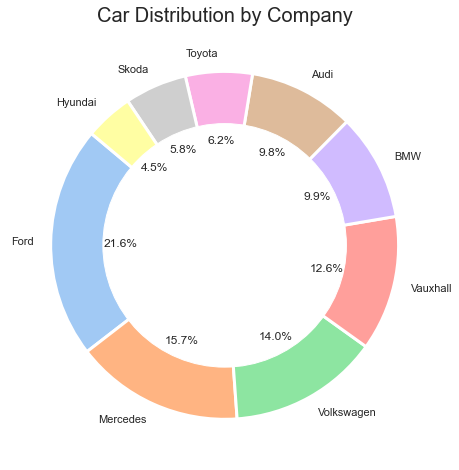

In [12]:
# Data Visualization
plot_company_distribution(full_data)

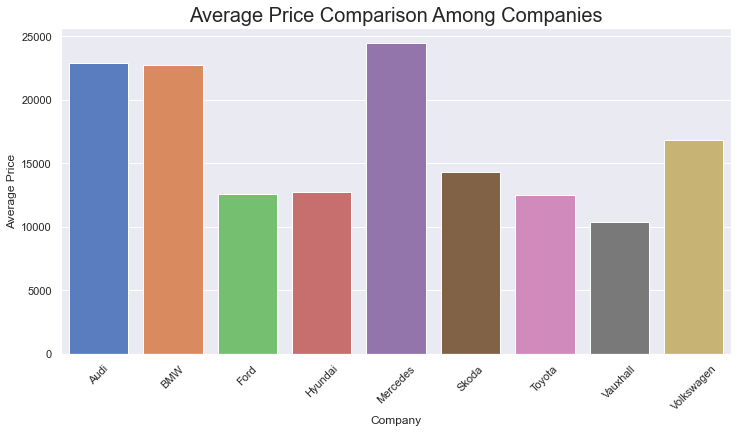

In [13]:
plot_price_comparison(full_data)

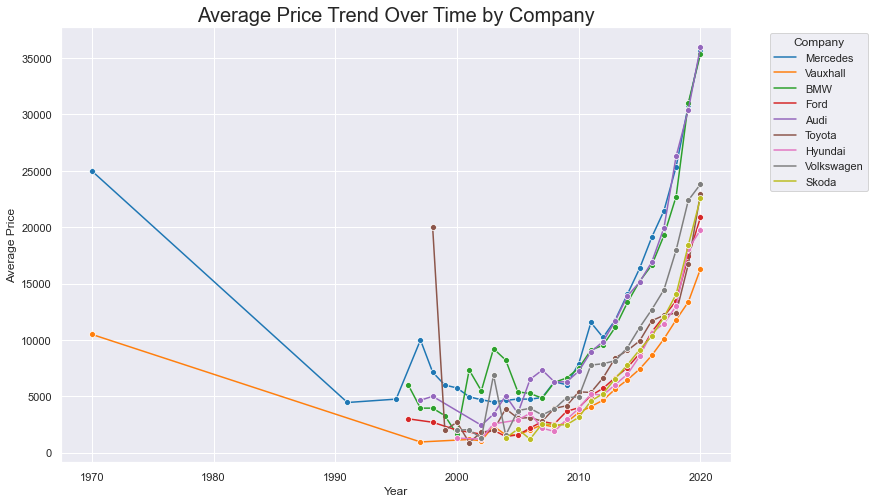

In [14]:
plot_price_trend_over_time(full_data)

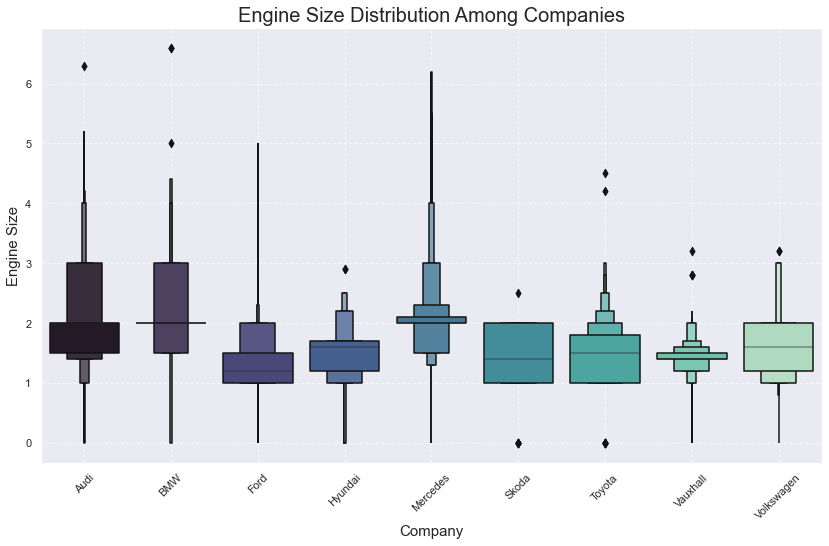

In [15]:
plot_engine_size_distribution(full_data)

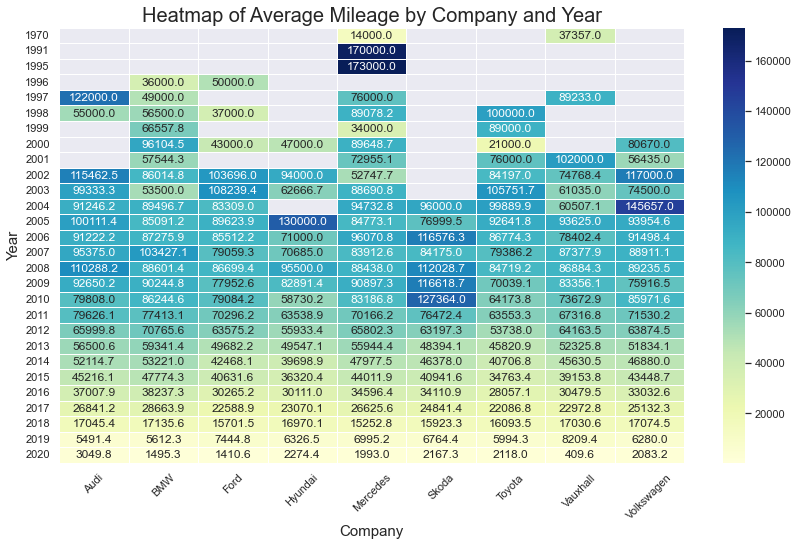

In [16]:
plot_mileage_heatmap(full_data)

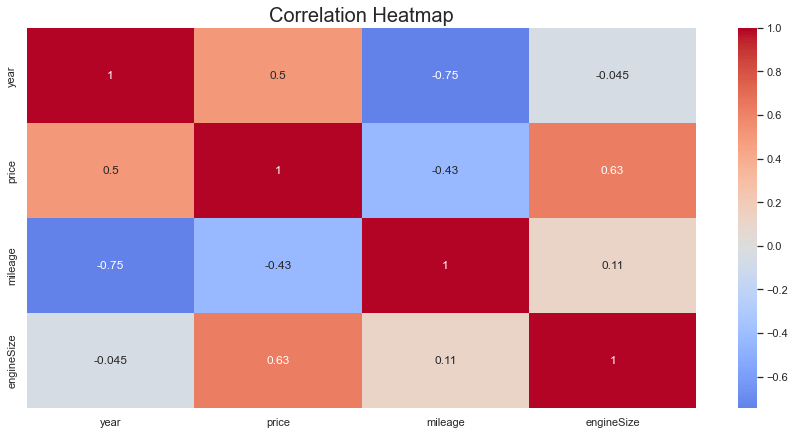

In [17]:
plot_correlation_heatmap(full_data)

## Encoding Categorial Variables

Making Copy of the orignal prepares data, and using it further

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for column in ['model', 'transmission', 'fuelType', 'company']:
    full_data[column] = encoder.fit_transform(full_data[column])


In [19]:
print("Encoded Data:")
print(full_data.head())

Encoded Data:
   model  year  price  transmission  mileage  fuelType  engineSize  company
0      9  2017  12500             1    15735         4         1.4        0
1     14  2016  16500             0    36203         0         2.0        0
2      9  2016  11000             1    29946         4         1.4        0
3     12  2017  16800             0    25952         0         2.0        0
4     11  2019  17300             1     1998         4         1.0        0


## Spliting Data

####  Spliting Data in to X and y

In [20]:
X = full_data.drop(columns=['price'])
y = full_data[['price']]

## Scaling Data Using MinMaxScaler()

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [22]:
print("\nFeatures (X):")
print(X.head())


Features (X):
   model  year  transmission  mileage  fuelType  engineSize  company
0      9  2017             1    15735         4         1.4        0
1     14  2016             0    36203         0         2.0        0
2      9  2016             1    29946         4         1.4        0
3     12  2017             0    25952         0         2.0        0
4     11  2019             1     1998         4         1.0        0


In [23]:
print("\nTarget (y):")
print(y.head())


Target (y):
   price
0  12500
1  16500
2  11000
3  16800
4  17300


In [24]:
print("\nScaled Features (X_scaled):")
print(X_scaled.head())


Scaled Features (X_scaled):
      model  year  transmission   mileage  fuelType  engineSize  company
0  0.046392  0.94      0.333333  0.048712       1.0    0.212121      0.0
1  0.072165  0.92      0.000000  0.112081       0.0    0.303030      0.0
2  0.046392  0.92      0.333333  0.092709       1.0    0.212121      0.0
3  0.061856  0.94      0.000000  0.080344       0.0    0.303030      0.0
4  0.056701  0.98      0.333333  0.006183       1.0    0.151515      0.0


## Spliting data in to Test Data and Train Data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=44)

# Training and Evaluating Regression Model

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Fitting the model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Reshape if necessary to avoid issues with dimensionality
    y_test_flat = np.ravel(y_test)
    predictions_flat = np.ravel(predictions)

    # Metrics Calculation
    mae = mean_absolute_error(y_test_flat, predictions_flat)
    mse = mean_squared_error(y_test_flat, predictions_flat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_flat, predictions_flat)

    # Visualization of Results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_flat, y=predictions_flat, alpha=0.6, color='green', label='Predicted vs Actual')
    sns.lineplot(x=y_test_flat, y=y_test_flat, color='blue', label='Ideal Fit')
    plt.title(f'Regression Results - {model_name}', fontsize=20)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.legend()
    plt.show()
    
    # Printing the metrics
    print(f"Results for {model_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R^2 Score: {r2:.4f}")  # Updated to 4 decimal places
    print("-" * 40)


## Decision Tree Regression

Evaluating Decision Tree Regressor...


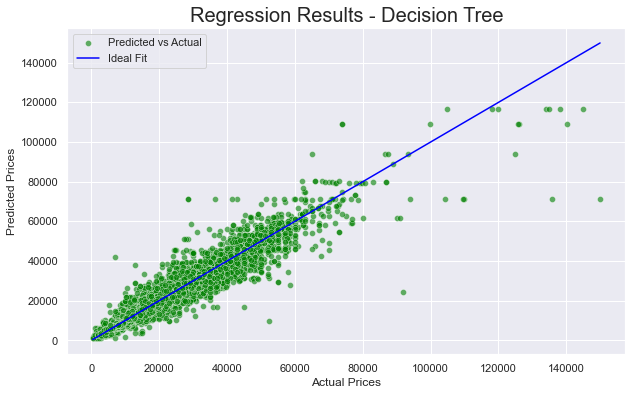

Results for Decision Tree:
MAE: 1508.38
MSE: 6919937.01
RMSE: 2630.58
R^2 Score: 0.9273
----------------------------------------


In [27]:
# Decision Tree Regressor
decision_tree = DecisionTreeRegressor(max_depth=18, min_samples_split=20)

print("Evaluating Decision Tree Regressor...")
train_evaluate_model(decision_tree, X_train, X_test, y_train, y_test, "Decision Tree")


In [28]:
# DataFrame for Decision Tree Boosting Predictions
DT_pred = decision_tree.predict(X_test)


## Gradient Boosting Regression

Evaluating Gradient Boosting Regressor...


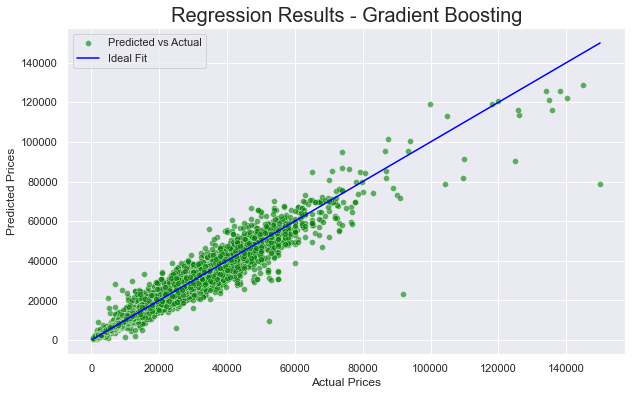

Results for Gradient Boosting:
MAE: 1369.61
MSE: 5046175.80
RMSE: 2246.37
R^2 Score: 0.9470
----------------------------------------


In [29]:
# Gradient Boosting Regressor
gradient_boosting = GradientBoostingRegressor(learning_rate=0.04, subsample=0.1, n_estimators=300, max_depth=20)
print("Evaluating Gradient Boosting Regressor...")
train_evaluate_model(gradient_boosting, X_train, X_test, y_train, y_test, "Gradient Boosting")

In [30]:
# DataFrame for Gradient Boosting Predictions
GB_pred = gradient_boosting.predict(X_test)

## Random Forest Regression

Evaluating Random Forest Regressor...


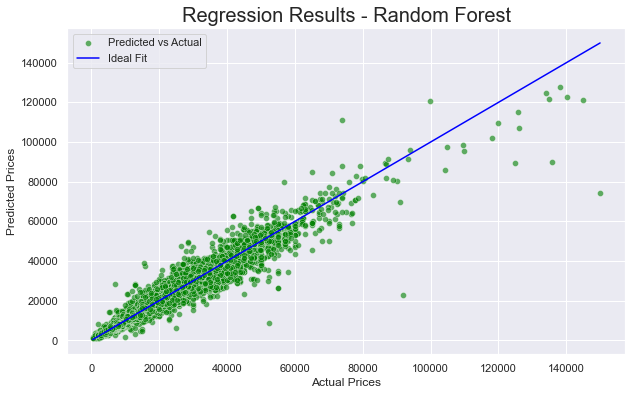

Results for Random Forest:
MAE: 1346.73
MSE: 5222815.84
RMSE: 2285.35
R^2 Score: 0.9451
----------------------------------------


In [31]:
# Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=1000, max_depth=20)

print("Evaluating Random Forest Regressor...")
train_evaluate_model(random_forest, X_train, X_test, y_train, y_test, "Random Forest")


In [32]:
# DataFrame for Random Forest Boosting Predictions
RF_pred = random_forest.predict(X_test)


## Linear Regression

Evaluating Linear Regression...


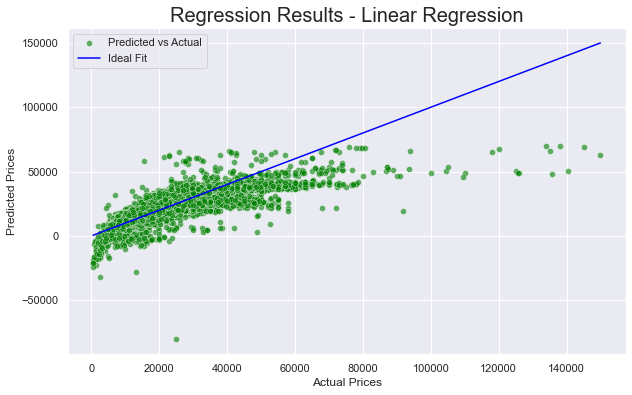

Results for Linear Regression:
MAE: 3470.95
MSE: 26970995.10
RMSE: 5193.36
R^2 Score: 0.7167
----------------------------------------


In [33]:
# Linear Regression Model
linear_regression = LinearRegression(fit_intercept=True, positive=False)

print("Evaluating Linear Regression...")
train_evaluate_model(linear_regression, X_train, X_test, y_train, y_test, "Linear Regression")

In [34]:
# DataFrame for Linear Regression Predictions
lr_pred = linear_regression.predict(X_test)


## Support Vector Machine

Evaluating Support Vector Machine Regressor...


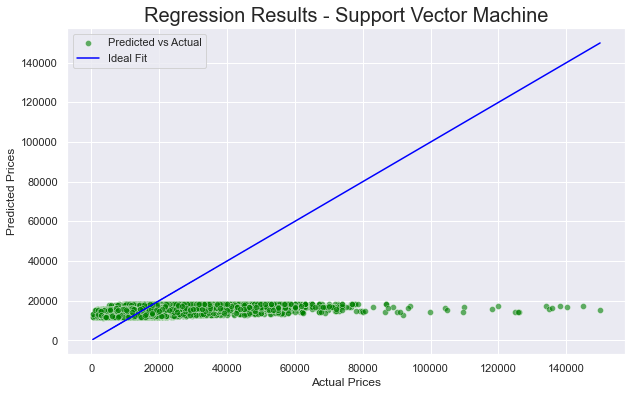

Results for Support Vector Machine:
MAE: 5994.24
MSE: 84420290.90
RMSE: 9188.05
R^2 Score: 0.1131
----------------------------------------


In [35]:
# Support Vector Machine Regressor
svm_regressor = SVR(kernel='rbf', C=1)
print("Evaluating Support Vector Machine Regressor...")
train_evaluate_model(svm_regressor, X_train, X_test, y_train, y_test, "Support Vector Machine")

In [36]:
# DataFrame for SVM Predictions
svm_pred = svm_regressor.predict(X_test)

## Comparison of All Model Predictions

   Actual           SVM            LR            RF            GB  \
0    8499  15223.719811  11323.993785   8727.705073   8325.068883   
1    7490  11891.378386   6440.489847   6615.682468   7513.946880   
2   14399  12086.099096  17515.621406  13594.307683  13701.021784   
3   12290  13074.132422  20727.363997  12423.836468  12763.105424   
4   13698  15387.500728  20455.729311  16200.719087  15308.524105   

             DT  
0   8564.600000  
1   6422.074074  
2  13610.529412  
3  12392.647059  
4  15058.764706  


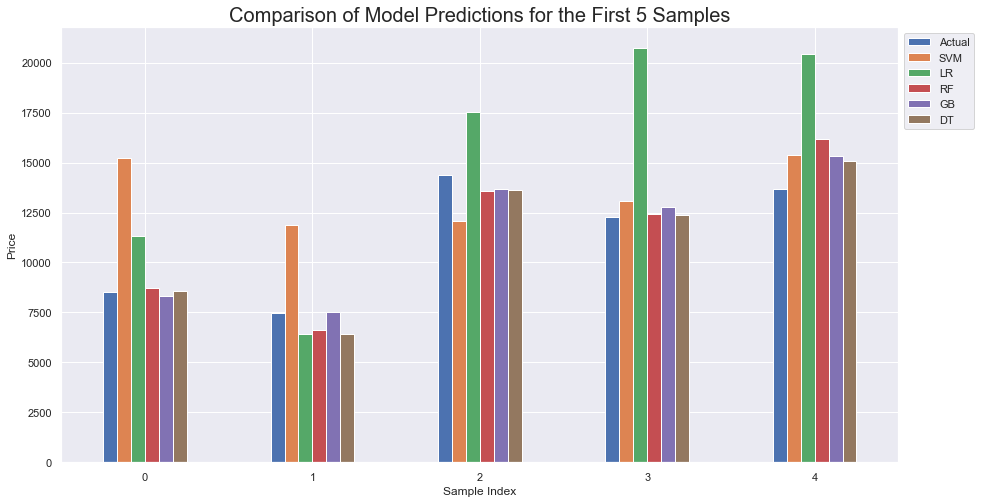

In [37]:
# Create a comparison DataFrame
comparison_df = pd.DataFrame()
comparison_df['Actual'] = y_test['price'].values
comparison_df['SVM'] = svm_pred
comparison_df['LR'] = lr_pred
comparison_df['RF'] = RF_pred
comparison_df['GB'] = GB_pred
comparison_df['DT'] = DT_pred

# Display the first 5 rows of the comparison dataframe
print(comparison_df.head())

# Create a bar plot for comparison_df.head()
comparison_df.head().plot(kind='bar', figsize=(15, 8))

# Adding labels and title
plt.title('Comparison of Model Predictions for the First 5 Samples', fontsize=20)
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position

# Display the plot
plt.show()
